# Research Assistant

**Objective**: Build a Lightweight , multi agent research system using LLM



In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from IPython.display import display, Image

load_dotenv()

True

In [15]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash")

## Generate Analysts : Human-In-The-Loop

Create analysts and review them using HITL

We create a set of analysts having different profiles. This step is to ensure that the research we perform carries information from the perspective of different experts.

In [107]:
from langgraph.graph import StateGraph, START, END
from typing import Optional, TypedDict, List
from pydantic import BaseModel, Field

# Analyst Profile Schema
class Analyst(BaseModel):
    affiliation:str = Field(description="Name of the primary affiliation of the analyst.")
    name:str = Field(description="Name of the analyst")
    role:str = Field(description="Role of the analyst in the context of the topic.")
    description:str = Field(description="A small description of the analyst's expertise.")

    @property
    def persona(self) -> str:
        return f"Name:{self.name}\nRole:{self.role}\nAffiliation:{self.affiliation}\nDescription:{self.description}"
    

class Perspectives(BaseModel):
    analysts:List[Analyst] = Field(description="Comprehensive list of the the analysts with their role and affiliations.")


class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions


In [147]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme.

6. Make sure that each analyst has an affiliation, name, role and description.
"""

In [171]:
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

# Define the node
def generate_analysts(state:GenerateAnalystsState):
    system_message = analyst_instructions.format(
        topic=state['topic'], 
        human_analyst_feedback=state.get('human_analyst_feedback',''),
        max_analysts=state['max_analysts']
        )
    response = llm.with_structured_output(Perspectives).invoke(
        [SystemMessage(content=system_message),
        HumanMessage(content="Generate the set of analysts.")])
    
    return {"analysts":response.analysts}

In [225]:
state = GenerateAnalystsState(
    {
        "max_analysts":3,
        "topic":"Number of girls entering teaching profession in India"
    }
)



In [172]:
generate_analysts(state=state)

{'analysts': [Analyst(affiliation='Stanford University', name='Dr. Alice Anderson', role='Strengths Analyst: Knowledge Graph Construction and Querying', description='Expert in graph databases and knowledge representation.'),
  Analyst(affiliation='Google AI', name='Bob Brown', role='Weaknesses Analyst: Scalability and Efficiency', description='Focuses on the scalability and efficiency of large language models.'),
  Analyst(affiliation='University of Oxford', name='Dr. Carol Clark', role='Ethical Implications Analyst: Bias and Fairness', description='Researches the ethical implications of AI technologies.')]}

In [200]:
def human_feedback(state:GenerateAnalystsState):
    pass

def should_continue(state:GenerateAnalystsState):
    human_feedback = state.get("human_analyst_feedback",None)

    if human_feedback:
        return "generate_analysts"
    else:
        return END


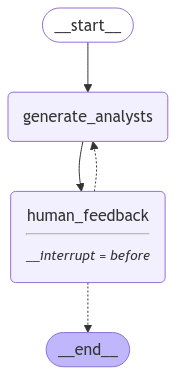

In [226]:
builder = StateGraph(GenerateAnalystsState)

builder.add_node("generate_analysts",generate_analysts)
builder.add_node("human_feedback",human_feedback)

builder.add_edge(START,"generate_analysts")
builder.add_edge("generate_analysts","human_feedback")
builder.add_conditional_edges("human_feedback",should_continue,["generate_analysts",  END])

memory = MemorySaver()

graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

display(Image(graph.get_graph().draw_mermaid_png()))

In [227]:
# Input
max_analysts = 3 
topic = "Number of girls entering teaching profession in India"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Anita Sharma
Affiliation: University of Delhi
Role: Lead Analyst: Socioeconomic Factors
Description: Expert in gender studies and education policy
--------------------------------------------------
Name: Mr. Rajesh Kumar
Affiliation: National Council for Teacher Education
Role: Analyst: Teacher Training and Development
Description: Specialist in teacher training and curriculum development
--------------------------------------------------
Name: Ms. Priya Iyer
Affiliation: Indian Institute of Management Bangalore
Role: Analyst: Labor Market Dynamics
Description: Expert in workforce trends and demographic analysis
--------------------------------------------------


In [212]:
graph.update_state(config=thread,as_node="human_feedback",values={
    "human_analyst_feedback":"Add in someone from a startup to add an entrepreneur perspective"
})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe2338-baae-69d5-8002-862bcc1808c6'}}

In [214]:
for event in graph.stream(None, config=thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Stanford University
Role: Lead Analyst:  Evaluating the efficiency gains of LangGraph as an agent framework.
Description: Expert in natural language processing and knowledge graph technologies.
--------------------------------------------------
Name: Dr. John Smith
Affiliation: Google AI
Role: Analyst: Assessing the scalability and maintainability of LangGraph-based agents.
Description: Experienced in large language model development and applications.
--------------------------------------------------
Name: Dr. Alice Johnson
Affiliation: University of Oxford
Role: Analyst: Investigating the potential of LangGraph for complex problem solving and decision-making.
Description: Specializes in agent-based modeling and simulation.
--------------------------------------------------
Name: Dr. Evelyn Reed
Affiliation: LangGraph Inc.
Role: Research Scientist
Description: Lead researcher focusing on LangGraph's performance and scalability in agent frameworks.
-

In [228]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
human_feedback


In [229]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Anita Sharma
Affiliation: University of Delhi
Role: Lead Analyst: Socioeconomic Factors
Description: Expert in gender studies and education policy
--------------------------------------------------
Name: Mr. Rajesh Kumar
Affiliation: National Council for Teacher Education
Role: Analyst: Teacher Training and Development
Description: Specialist in teacher training and curriculum development
--------------------------------------------------
Name: Ms. Priya Iyer
Affiliation: Indian Institute of Management Bangalore
Role: Analyst: Labor Market Dynamics
Description: Expert in workforce trends and demographic analysis
--------------------------------------------------


In [230]:
final_state

StateSnapshot(values={'topic': 'Number of girls entering teaching profession in India', 'max_analysts': 3, 'analysts': [Analyst(affiliation='University of Delhi', name='Dr. Anita Sharma', role='Lead Analyst: Socioeconomic Factors', description='Expert in gender studies and education policy'), Analyst(affiliation='National Council for Teacher Education', name='Mr. Rajesh Kumar', role='Analyst: Teacher Training and Development', description='Specialist in teacher training and curriculum development'), Analyst(affiliation='Indian Institute of Management Bangalore', name='Ms. Priya Iyer', role='Analyst: Labor Market Dynamics', description='Expert in workforce trends and demographic analysis')]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efe3265-c4f4-6105-8002-8c2133ef2c69'}}, metadata={'source': 'loop', 'writes': {'human_feedback': None}, 'thread_id': '1', 'step': 2, 'parents': {}}, created_at='2025-02-04T18:32:16.873471+00:00', parent_conf

## Conduct Interview

In [231]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns:int = Field(description="Maximum number of interview questions to be asked to the analyst.")
    context:Annotated[list[str],operator.add] = Field(description="A list of all the source docs")
    analyst:Analyst = Field(description="The analyst whic is asking questions")
    interview:str = Field(description="Transcript of the interview")
    sections:list[str] = Field(description="Final key we duplicate in outer state for Send() API")


class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [232]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

## Answer Generation

In [233]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader
tavily_search = TavilySearchResults(max_results=3)

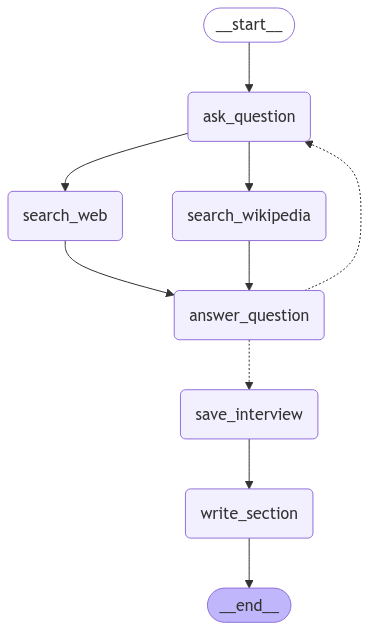

In [234]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [235]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

##  India's Evolving Educational Landscape: Women Teachers Leading the Way

### Summary

The educational landscape in India is experiencing a significant shift, particularly concerning the participation and roles of women. While historical and ongoing gender disparities persist in access to and completion of education [1, 3], a compelling trend has emerged: a substantial increase in the number of women employed as teachers, especially at the primary school level [2].  This is not simply a matter of more women entering the profession; rather, it represents a substantial majority.  Data indicates that women now constitute over half (53.3%) of all school teachers in India [4], marking a historic high. This surge in female representation in teaching contrasts with the broader trends in women's employment, where older women with lower levels of education are often leaving the workforce [5].  This suggests that teaching is an attractive career path for women, particularly those with higher education levels [5].  While the 1986 National Policy on Education recommended increased female representation in secondary schools [6], the current reality surpasses this goal, and extends to primary education where women are significantly more prevalent than men in this profession [2].  The increasing presence of women in education, particularly in teaching, presents a fascinating case study in the intersection of gender, education policy, and workforce dynamics in India. This trend requires further investigation to understand its implications for educational quality, gender equality, and overall societal development.


1. [1] https://www.researchgate.net/publication/381284005_Women's_Employment_and_Education_Trends_in_India_After_1991
2. [2] https://mospi.gov.in/sites/default/files/publication_reports/women-men22/EducationStatistics22.pdf
3. [3] https://www.indiatoday.in/education-today/featurephilia/story/understanding-the-gender-disparities-in-indian-education-2579174-2024-08-14
4. [4] https://www.indiatoday.in/education-today/news/story/female-teachers-now-lead-indias-school-education-workforce-education-report-2660385-2025-01-06
5. [5] https://www.orfonline.org/expert-speak/the-female-workforce-in-india-emerging-trends-and-insights
6. [6] https://utoronto.scholaris.ca/items/74707a1a-81bf-41e6-91f4-6102fc82df16


### Sources
[1] https://www.researchgate.net/publication/381284005_Women's_Employment_and_Education_Trends_in_India_After_1991  
[2] https://mospi.gov.in/sites/default/files/publication_reports/women-men22/EducationStatistics22.pdf  
[3] https://www.indiatoday.in/education-today/featurephilia/story/understanding-the-gender-disparities-in-indian-education-2579174-2024-08-14  
[4] https://www.indiatoday.in/education-today/news/story/female-teachers-now-lead-indias-school-education-workforce-education-report-2660385-2025-01-06  
[5] https://www.orfonline.org/expert-speak/the-female-workforce-in-india-emerging-trends-and-insights  
[6] https://utoronto.scholaris.ca/items/74707a1a-81bf-41e6-91f4-6102fc82df16